<a href="https://colab.research.google.com/github/jwzimmer/character-space/blob/main/characterspace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Step 1: SVD
Import the packages used.

In [ ]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import linalg
import matplotlib.pyplot as plt
import seaborn as sns

Load the data, a matrix of 800 fictional characters and 236 bipolar adjective pairs, from Julia's GitHub repo. The original data is from OpenPsychometrics.org: https://openpsychometrics.org/_rawdata/, in the file "characters-aggregated.zip". This matrix excluded the emoji differentials from the original data, and includes the original character label ("unnamed.1"), the work the character is from ("work"), and the name of the character ("name").

In [ ]:
path_to_df_of_data = "https://raw.githubusercontent.com/jwzimmer/tv-tropening/main/July2021_df_traits.json"
traits_df = pd.read_json(path_to_df_of_data)

Before running SVD, we have to drop the three columns that aren't trait differentials/ bipolar adjective pairs.

In [ ]:
drop_columns=['unnamed.1','name','work']
traits_only_df = traits_df
for column in drop_columns:
  traits_only_df = traits_only_df.drop(column, axis=1)

We then subtract the theoretical mean of the scores. We used 50 because the characters were assigned scores for each trait differential on a scale from 0 - 100.

In [ ]:
traits_df_normed = traits_only_df - 50

## The actual SVD part

Suppose we have a matrix $X$ of size $M{\times}N$. SVD decomposes this matrix into the product of three factors where $$X = U {\Sigma} {V^{T}}{\text{.}}$$ $U$ and $V$ are orthogonal matrices. The columns of $U$ contain the left singular vectors of $X$, the rows of ${V}^{T}$ contain the right singular values of $X$, and along the diagonal of $\Sigma$ are the singular values of $X$ ordered by descending importance.

What's important is that we can use $U$, ${\Sigma}$, and $V^{T}$ to reconstruct $X$ as the sum of rank 1 matrices such that $$X={\sigma_1}{u_1}{v_1}^{T}+{\sigma_2}{u_2}{v_2}^{T}+{\cdots}+{\sigma_p}{u_p}{v_p}^{T}$$ where ${\sigma_1}{u_1}{v_1}^{T}$ explains the most variance, followed by ${\sigma_2}{u_2}{v_2}^{T}$, and so on up to $p \leq {N}$. Because the trailing terms explain the least variance, they can be truncated without a significant loss of information. The result is a lower-rank matrix, say a rank 3 matrix $X'$, that well approximates $X$: $$X' = {\sigma_1}{u_1}{v_1}^{T}+{\sigma_2}{u_2}{v_2}^{T}+{\sigma_3}{u_3}{v_3}^{T}$$. Note that the parts of the matrix decomposition produced by SVD are almost unique, except that their signs (as in, positive or negative) could flip without impacting the reconstruction of the original matrix.

The function for running SVD on the matrix, which returns df1, the dataframe that was passed into it, U, D, V, and Sig, which are all SVD outputs, X, which is the actual matrix SVD was run on, and remakeX, which is the reconstruction of X using the SVD outputs.

In [ ]:
def runSVD(df1):
    """ df1 is the dataframe you want to run SVD on;
    this function is mostly copy-pasted from https://stackoverflow.com/questions/55777664/getting-singular-values-of-numpy-data-columns-in-order/55785021
    """
    X = df1.to_numpy()
    #decompose
    U, D, V = np.linalg.svd(X)
    # get dim of X
    M,N = X.shape
    # Construct sigma matrix in SVD (it simply adds null row vectors to match the dim of X)
    Sig = sp.linalg.diagsvd(D,M,N)
    # Now you can get X back:
    remakeX = np.dot(U, np.dot(Sig, V))
    assert np.sum(remakeX - X) < 0.00001
    return df1, U, D, V, Sig, X, remakeX

In [ ]:
df_svd, U, D, V, Sig, X, remakeX = runSVD(traits_df_normed)

The list of all the trait differentials in the order they're in for the matrix we ran SVD on:

In [ ]:
trait_columns = df_svd.columns

#Step 2: Analysis
Now that we have the output from SVD, we can analyze it.

##Comparison with Power, Danger, Structure framework

Our goal is to find any words from our trait differentials that have a score in the PDS dataset, to relabel the trait with the most appropriate P,D, or S, and then to see what the results of SVD look like. If our first three dimensions (Heroes and Zeroes, Saints and Sinners, and Bohemians and Bureacrats) are related to PDS, that pattern will hopefully be obvious.

Load the words and their scores via Professor Peter Dodds:

In [ ]:
word_df = pd.read_csv("http://pdodds.w3.uvm.edu/permanent-share/ousiometry_data.txt", sep="\t")

We will need the standard deviations for P, D, and S later. The SD for P, D is in the relevant paper (https://arxiv.org/abs/2110.06847), so we just need to find the SD for structure: 0.09744511833639315

Get the list of words from our trait differentials:

In [ ]:
trait_words = []
for z in trait_columns:
    trait_words += z.split("<->")

354 of our 472 trait words are in the PDS dataset. We need to find the P, D, and S score for each of those words:

In [ ]:
shared_words = list(set(list(word_df["word"])).intersection(set(trait_words))) #length is 354

backwards_word_dict = word_df["word"].to_dict()
word_dict = {y:x for x,y in backwards_word_dict.items()}

In [ ]:
sd_p = 0.218
sd_d = 0.218
sd_s = 0.097

power_score_dict = {x: word_df["power"][word_dict[x]]/sd_p for x in shared_words}
danger_score_dict = {x: word_df["danger"][word_dict[x]]/sd_d for x in shared_words}
structure_score_dict = {x: word_df["structure"][word_dict[x]]/sd_s for x in shared_words}

### Display style 1 & 2

We need to either choose a threshold for when to consider a word P, D, or S, or we could pick whichever the word is most like and label it as that. We're trying the latter first. We also need to reflect whether it has a negative or positive score for that word... a large negative score for e.g. power would mean the word is strongly not powerful.

Want to use different thresholds based on SD; want to use difference between endpoint words when both are in dataset; want to include scores in charts.

In [ ]:
word_categories = {}

for w in shared_words:
    p,d,s = power_score_dict[w], danger_score_dict[w], structure_score_dict[w]
    abs_dict = {abs(p):"power", abs(d):"danger", abs(s):"structure"}
    backwards_abs_dict = {y:x for x,y in abs_dict.items()}
    small_score_dict = {"power":p,"danger":d,"structure":s}
    max_abs_score = max(abs(p),abs(d),abs(s))
    # if two categories have the same score and that is the highest score, the word should not be labeled... 
    # for now we're going the easy route and just throwing out words with the same scores for any two categories
    same_score = 0
    if len(list(set([p,d,s]))) != 3:
        same_score = 1
    if same_score:
        pass
    else:
        # relabeling based on thresholds
        # from arxiv ousiometrics paper, SD = 0.218 for P and D
        # SD = 0.097 for S
        standard_dev_threshold_dict = {"power": 0.218, "danger": 0.218, "structure": 0.097}
        largest_score_category = abs_dict[max_abs_score]
        if max_abs_score > standard_dev_threshold_dict[largest_score_category]:
            if backwards_abs_dict[largest_score_category] == small_score_dict[largest_score_category]:
                word_category = "+ " + largest_score_category
            else:
                word_category = "- " + largest_score_category
            word_categories[w] = word_category
        else: pass

Now that we have categories of P, D, or S for the trait words, we need to relabel the trait differentials with those categories.

In [ ]:
trait_columns_relabeled = []

for trait_pair in trait_columns:
  left_anchor, right_anchor = trait_pair.split("<->")
  if left_anchor in word_categories:
    left_anchor = word_categories[left_anchor]
  if right_anchor in word_categories:
    right_anchor = word_categories[right_anchor]
  trait_columns_relabeled.append(left_anchor+" vs. "+right_anchor)

### Calculating the deltas

Alternately, if we want to look at the difference between the PDS scores across the anchor words:

In [ ]:
trait_columns_changes = {}

sd_p = 0.218
sd_d = 0.218
sd_s = 0.097

for trait_pair in trait_columns:
  left_anchor, right_anchor = trait_pair.split("<->")
  if left_anchor in shared_words:
    left_p = power_score_dict[left_anchor]
    left_d = danger_score_dict[left_anchor]
    left_s = structure_score_dict[left_anchor]
  if right_anchor in shared_words:
    right_p = power_score_dict[right_anchor]
    right_d = danger_score_dict[right_anchor]
    right_s = structure_score_dict[right_anchor]
  if left_anchor in shared_words and right_anchor in shared_words:
    change_p = right_p - left_p
    change_d = right_d - left_d
    change_s = right_s - left_s
    change_abs_dict = {abs(change_p):"power", abs(change_d):"danger", abs(change_s):"structure"}
    backwards_change_abs_dict = {y:x for x,y in change_abs_dict.items()}
    small_change_dict = {"power":change_p,"danger":change_d,"structure":change_s}
    max_abs_change = max(abs(change_p),abs(change_d),abs(change_s)) 
    # for now we're going the easy route and just throwing out words with the same change differences for any two categories
    same_score = 0
    if len(list(set([change_p,change_d,change_s]))) != 3:
        same_score = 1
    if same_score:
          pass
    else:
      largest_change_category = change_abs_dict[max_abs_change]
      if backwards_change_abs_dict[largest_change_category] == small_change_dict[largest_change_category]:
        change_category = "+ " + largest_change_category
      else:
        change_category = "- " + largest_change_category
      trait_columns_changes[trait_pair] = change_category



It is sloppy to repeat code, but for now I want to see if I can get it working... should give us a dict with trait differentials to normed deltas

In [ ]:
normed_deltas = {}

triple_deltas = {}

for trait_pair in trait_columns:
  left_anchor, right_anchor = trait_pair.split("<->")
  if left_anchor in shared_words:
    left_p = power_score_dict[left_anchor]
    left_d = danger_score_dict[left_anchor]
    left_s = structure_score_dict[left_anchor]
  if right_anchor in shared_words:
    right_p = power_score_dict[right_anchor]
    right_d = danger_score_dict[right_anchor]
    right_s = structure_score_dict[right_anchor]
  if left_anchor in shared_words and right_anchor in shared_words:
    change_p = (right_p - left_p)
    change_d = (right_d - left_d)
    change_s = (right_s - left_s)
    change_abs_dict = {abs(change_p):"power", abs(change_d):"danger", abs(change_s):"structure"}
    backwards_change_abs_dict = {y:x for x,y in change_abs_dict.items()}
    small_change_dict = {"power":change_p,"danger":change_d,"structure":change_s}
    max_abs_change = max(abs(change_p),abs(change_d),abs(change_s)) 
    # for now we're going the easy route and just throwing out words with the same change differences for any two categories
    same_score = 0
    if len(list(set([change_p,change_d,change_s]))) != 3:
        same_score = 1
    if same_score:
          pass
    else:
      triple_deltas[trait_pair] = "({:0.2f}".format(small_change_dict["power"])+", {:0.2f}".format(small_change_dict["danger"])+", {:0.2f})".format(small_change_dict["structure"])
      largest_change_category = change_abs_dict[max_abs_change]
      if backwards_change_abs_dict[largest_change_category] == small_change_dict[largest_change_category]:
        change_category = "+ {:0.2f}".format(max_abs_change)
      else:
        change_category = "- {:0.2f}".format(max_abs_change)
      normed_deltas[trait_pair] = change_category

We need a list of all the trait column names in order, including the relabeled and unrelabeled ones (that didn't have a score in PDS):

In [ ]:
trait_columns_changes_relabeled = []
for trait_pair in trait_columns:
  if trait_pair in trait_columns_changes:
    trait_columns_changes_relabeled.append(trait_columns_changes[trait_pair])
  else:
    #l, r = trait_pair.split("<->")
    #trait_columns_changes_relabeled.append(l + " vs. " + r)
    trait_columns_changes_relabeled.append("--")

A list of all the trait column names in order, but just the normed deltas

In [ ]:
normed_delta_columns_relabeled = []
for trait_pair in trait_columns:
  if trait_pair in normed_deltas:
    normed_delta_columns_relabeled.append(normed_deltas[trait_pair])
  else:
    normed_delta_columns_relabeled.append("--")

A list of all the trait column names in order but using the triplet normed deltas (based on the normed PDS scores)

In [ ]:
triple_delta_columns_relabeled = []
for trait_pair in trait_columns:
  if trait_pair in triple_deltas:
    triple_delta_columns_relabeled.append(triple_deltas[trait_pair])
  else:
    triple_delta_columns_relabeled.append("--")

A function to create a bar chart to show the magnitudes of the most important traits (or characters) in each dimension:

In [ ]:
def vector_barchart(vector_names,vector,n,style="by_mag",ascending=False):
    """ vector_names should be the labels for the values in the vector
        vector should be the vector (ndarray)
        n should be the number of values you want displayed in the chart
        style should be the format of the chart
        ascending=False will be most relevant traits by magnitude,
        ascending=True will be least relevant traits by magnitude"""
    n=min(n,len(vector_names))
    vectordf = pd.DataFrame()
    vectordf["Trait"] = vector_names
    vectordf["Values"] = vector
    
    if style=="by_mag":
        vectordf["Magnitude"] = vectordf.apply(lambda row: abs(row["Values"]), axis = 1)
        sorteddf = vectordf.sort_values(by="Magnitude",ascending=ascending)
        #plotguy = sorteddf.iloc[-2*n:].iloc[::-1]
        plotguy = sorteddf.iloc[0:2*n]
    #sns.set(font_scale = 2)
    sns.barplot(plotguy["Values"],plotguy["Trait"],ci=None)
    #sns.set(font_scale = 1)
    return vectordf, plotguy

To see the dimensions:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


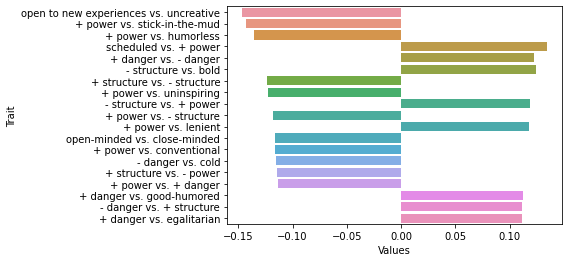

In [ ]:
vectordf, plotguy = vector_barchart(trait_columns_relabeled,V[2,:],10)

The magnitudes associated with the traits within each row of $V^T$ are old information to us at this point... so looking just at the labels of the traits, using a threshold of 0.4 (for the PDS scores), for dimension 1: 10P, 2D, 0S, for dimension 2: 4P, 9D, 0S, for dimension 3: 4P, 4D, 0S.

A function to show just the labels (no magnitudes) and the P,D,S scores:

In [ ]:
def vector_ordered_by_magnitude(vector_names,vector):
    """ vector_names should be the labels for the values in the vector
        vector should be the vector (ndarray)"""
    #n=min(n,len(vector_names))
    vectordf = pd.DataFrame()
    vectordf["Trait"] = vector_names
    vectordf["Values"] = vector
    vectordf["Magnitude"] = vectordf.apply(lambda row: abs(row["Values"]), axis = 1)
    sorteddf = vectordf.sort_values(by="Magnitude",ascending=False)
    # if we want to return a truncated list instead of all traits, return plotguy
    #plotguy = sorteddf.iloc[0:2*n]
    return sorteddf["Trait"]

In [ ]:
ordered_relabeled_traits_in_dimensions_df = pd.DataFrame()
ordered_relabeled_traits_in_dimensions_df["power/ 1st dim"] = list(vector_ordered_by_magnitude(trait_columns_relabeled,V[0,:]))
ordered_relabeled_traits_in_dimensions_df["danger/ 2nd dim"] = list(vector_ordered_by_magnitude(trait_columns_relabeled,V[1,:]))
ordered_relabeled_traits_in_dimensions_df["structure/ 3rd dim"] = list(vector_ordered_by_magnitude(trait_columns_relabeled,V[2,:]))


Printing this object and pasting it in something that reads markdown (like these text cells) will display the chart of the relabeled traits for the first 3 dimensions (more can be added following the format above):

In [ ]:
markdown_object_to_print = ordered_relabeled_traits_in_dimensions_df.to_markdown()

### Display style 3

We want to show the original trait word, but show the P,D,S scores next to them.

In [ ]:
trait_columns_with_scores = []

for trait_pair in trait_columns:
  left_anchor, right_anchor = trait_pair.split("<->")
  #left
  if left_anchor in power_score_dict:
    left_anchor_p = power_score_dict[left_anchor]
  else:
    left_anchor_p = ""
  if left_anchor in danger_score_dict:
    left_anchor_d = danger_score_dict[left_anchor]
  else:
    left_anchor_d = ""
  if left_anchor in structure_score_dict:
    left_anchor_s = structure_score_dict[left_anchor]
  else:
    left_anchor_s = ""
  #right
  if right_anchor in power_score_dict:
    right_anchor_p = power_score_dict[right_anchor]
  else:
    right_anchor_p = ""
  if right_anchor in danger_score_dict:
    right_anchor_d = danger_score_dict[right_anchor]
  else:
    right_anchor_d = ""
  if right_anchor in structure_score_dict:
    right_anchor_s = structure_score_dict[right_anchor]
  else:
    right_anchor_s = ""

  if left_anchor_p == "":
    new_left_anchor = left_anchor
  else:
    new_left_anchor = left_anchor+" ({:0.2f}".format(left_anchor_p)+", {:0.2f}".format(left_anchor_d)+", {:0.2f})".format(left_anchor_s)
  if right_anchor_p == "":
    new_right_anchor = right_anchor
  else:
    new_right_anchor = right_anchor+" ({:0.2f}".format(right_anchor_p)+", {:0.2f}".format(right_anchor_d)+", {:0.2f})".format(right_anchor_s)

  trait_columns_with_scores.append(new_left_anchor+" vs. "+new_right_anchor)

In [ ]:
ordered_scored_traits_in_dimensions_df = pd.DataFrame()
ordered_scored_traits_in_dimensions_df["power/ 1st dim"] = list(vector_ordered_by_magnitude(trait_columns_with_scores,V[0,:]))
ordered_scored_traits_in_dimensions_df["danger/ 2nd dim"] = list(vector_ordered_by_magnitude(trait_columns_with_scores,V[1,:]))
ordered_scored_traits_in_dimensions_df["structure/ 3rd dim"] = list(vector_ordered_by_magnitude(trait_columns_with_scores,V[2,:]))

In [ ]:
markdown_object_to_print_2 = ordered_scored_traits_in_dimensions_df.to_markdown()

### Display style 4: using the difference in scores across the traits

In [ ]:
ordered_changes_traits_in_dimensions_df = pd.DataFrame()
ordered_changes_traits_in_dimensions_df["power/ 1st dim"] = list(vector_ordered_by_magnitude(trait_columns_changes_relabeled,V[0,:]))
ordered_changes_traits_in_dimensions_df["danger/ 2nd dim"] = list(vector_ordered_by_magnitude(trait_columns_changes_relabeled,V[1,:]))
ordered_changes_traits_in_dimensions_df["structure/ 3rd dim"] = list(vector_ordered_by_magnitude(trait_columns_changes_relabeled,V[2,:]))

In [ ]:
markdown_object_to_print_3 = ordered_changes_traits_in_dimensions_df.to_markdown()

## Comparison with lower dimensions
For comparison, do the 4th, 5th and 6th dimensions have a clear pattern?

In [ ]:
dimensions_4_5_6_df = pd.DataFrame()
dimensions_4_5_6_df["4th dim"] = list(vector_ordered_by_magnitude(trait_columns_changes_relabeled,V[3,:]))
dimensions_4_5_6_df["5th dim"] = list(vector_ordered_by_magnitude(trait_columns_changes_relabeled,V[4,:]))
dimensions_4_5_6_df["6th dim"] = list(vector_ordered_by_magnitude(trait_columns_changes_relabeled,V[5,:]))

In [ ]:
print(dimensions_4_5_6_df.to_markdown())

## A larger chart

* One dimension per chart
* Original semantic diff;
* PDS scores for each end (— not available);
* normalized PDS; delta in PDS (triple);
* normalized deltas in PDS (triple);
* changes with words power, danger, structure;
* Words substituted into semantic diff.



In [ ]:
def larger_chart(original_vector_names,
                 relabeled_vector_names,
                 triple_delta_names,
                 normed_delta_names,
                 vector):
    """ vector_names should be the labels for the values in the vector
        vector should be the vector (ndarray)"""
    #n=min(n,len(vector_names))
    vectordf = pd.DataFrame()
    vectordf["Traits and normalized PDS scores"] = original_vector_names
    vectordf["Relabeled traits"] = relabeled_vector_names
    vectordf["Changes in PDS scores"] = triple_delta_names
    vectordf["Largest delta"] = normed_delta_names
    vectordf["Values"] = vector
    vectordf["Magnitude"] = vectordf.apply(lambda row: abs(row["Values"]), axis = 1)
    #sorteddf = pd.DataFrame(np.sort(vectordf.values, axis=0), index=vectordf.index, columns=vectordf.columns)
    sorteddf = vectordf.sort_values(by="Magnitude",ascending=False)
    # if we want to return a truncated list instead of all traits, return plotguy
    #plotguy = sorteddf.iloc[0:2*n]
    return sorteddf

* trait_columns_with_scores has the original (not normalized) PDS scores
* trait_columns_changes_relabeled has the original (not normalized) deltas

In [ ]:
larger_chart_df = larger_chart(trait_columns_with_scores,trait_columns_changes_relabeled,triple_delta_columns_relabeled,normed_delta_columns_relabeled,V[2,:])

In [ ]:
print(larger_chart_df.head(25)[["Traits and normalized PDS scores","Relabeled traits","Changes in PDS scores"]].to_markdown(index="False"))

| Traits and normalized PDS scores                                   | Relabeled traits   | Changes in PDS scores   |
|:-------------------------------------------------------------------|:-------------------|:------------------------|
| diligent (1.29, -1.05, -0.97) vs. lazy (-2.11, -0.47, 1.01)        | - power            | (**-3.40**, 0.58, 1.98)     |
| competent (2.31, -0.94, -0.73) vs. incompetent (-1.56, 1.38, 0.42) | - power            | (**-3.87**, 2.32, 1.15)     |
| disorganized (-2.06, 1.45, 0.08) vs. self-disciplined              | --                 | --                      |
| workaholic (0.18, 1.03, -0.29) vs. slacker                         | --                 | --                      |
| high IQ vs. low IQ                                                 | --                 | --                      |
| persistent (1.74, 0.11, -0.58) vs. quitter (-1.23, 0.64, -0.14)    | - power            | (**-2.98**, 0.53, 0.44)     |
| unambitious vs. driven                                             | --                 | --                      |
| resourceful (2.66, -0.63, 0.41) vs. helpless (-2.03, 1.01, -0.37)  | - power            | (**-4.69**, 1.63, -0.78)    |
| studious vs. goof-off                                              | --                 | --                      |
| coordinated vs. clumsy (-2.21, 0.92, 0.23)                         | --                 | --                      |
| noob (-1.12, 0.01, 0.85) vs. pro (0.95, -0.61, -0.70)              | + power            | (**2.07**, -0.62, -1.56)    |
| slugabed vs. go-getter                                             | --                 | --                      |
| active (2.06, -0.38, 1.36) vs. slothful                            | --                 | --                      |
| valedictorian (0.29, -0.01, -0.72) vs. drop out                    | --                 | --                      |
| works hard vs. plays hard                                          | --                 | --                      |
| legit (1.56, -0.98, -1.67) vs. scrub (-0.37, 0.02, -0.86)          | - power            | (**-1.93**, 1.00, 0.81)     |
| dunce (-2.27, 0.42, 0.00) vs. genius (2.38, -0.66, 0.35)           | + power            | (**4.65**, -1.08, 0.34)     |
| loyal (0.91, -2.03, -0.48) vs. traitorous (-0.73, 2.17, -0.10)     | + danger           | (-1.64, **4.20**, 0.38)     |
| gossiping vs. confidential (1.13, -0.51, -1.31)                    | --                 | --                      |
| trash (-1.83, 1.18, 1.03) vs. treasure (2.24, -1.06, 0.34)         | + power            | (**4.07**, -2.24, -0.68)    |
| juvenile (0.47, -0.62, 0.64) vs. mature (0.28, -0.88, -0.95)       | - structure        | (-0.19, -0.26, **-1.59**)   |
| alert (1.14, 1.11, 0.64) vs. oblivious (-1.35, 0.52, -0.93)        | - power            | (**-2.49**, -0.59, -1.58)   |
| racist (-0.68, 2.00, -1.06) vs. egalitarian                        | --                 | --                      |
| important (2.15, -0.61, -0.04) vs. irrelevant (-1.92, 0.56, -1.40) | - power            | (**-4.07**, 1.17, -1.35)    |
| apprentice (-0.09, -0.67, 0.42) vs. master (1.58, -0.61, -1.58)    | - structure        | (1.67, 0.06, **-2.00**)     |

| Traits and normalized PDS scores                                    | Relabeled traits   | Changes in PDS scores   |
|:--------------------------------------------------------------------|:-------------------|:------------------------|
| competitive (1.71, 0.95, -1.93) vs. cooperative (1.20, -1.14, 0.13) | - danger           | (-0.51, **-2.08**, 2.06)    |
| arrogant (-0.06, 2.10, -1.03) vs. humble (0.20, -2.06, 0.45)        | - danger           | (0.26, **-4.16**, 1.48)     |
| forgiving (0.66, -1.84, 0.47) vs. vengeful (0.15, 2.25, -0.25)      | + danger           | (-0.52, **4.09**, -0.72)    |
| quarrelsome vs. warm (0.46, -1.44, -0.38)                           | --                 | --                      |
| ferocious (1.06, 2.47, -1.27) vs. pacifist (-0.20, -1.63, -1.55)    | - danger           | (-1.26, **-4.10**, -0.28)   |
| mischievous (0.43, 1.16, 1.61) vs. well behaved                     | --                 | --                      |
| moderate (-0.65, -1.26, -1.00) vs. extreme (0.98, 1.60, -0.78)      | + danger           | (1.62, **2.86**, 0.22)      |
| shy (-2.49, -0.44, -0.42) vs. bold (-0.58, -0.69, -1.21)            | + power            | (**1.90**, -0.25, -0.79)    |
| trusting (1.66, -1.11, 0.03) vs. suspicious (-0.49, 1.91, 0.16)     | + danger           | (-2.15, **3.02**, 0.13)     |
| bossy (0.95, 1.94, -1.24) vs. meek (-1.70, -1.27, 0.33)             | - danger           | (-2.65, **-3.20**, 1.57)    |
| dominant (1.87, 1.51, -1.26) vs. submissive (-1.75, -0.89, 0.63)    | - power            | (**-3.62**, -2.40, 1.90)    |
| feisty (1.94, 0.87, 0.39) vs. gracious (1.70, -0.94, 1.84)          | - danger           | (-0.24, **-1.80**, 1.46)    |
| bitter (-0.66, 1.32, -0.04) vs. sweet (-0.19, -0.84, 1.21)          | - danger           | (0.47, **-2.16**, 1.25)     |
| angelic (1.09, -2.02, -0.22) vs. demonic (0.34, 2.38, -0.35)        | + danger           | (-0.74, **4.40**, -0.13)    |
| assertive (1.20, -0.95, -1.33) vs. passive (-1.88, -1.00, -0.71)    | - power            | (**-3.09**, -0.05, 0.62)    |
| debased (-1.67, 0.96, 1.12) vs. pure (0.79, -1.62, -0.64)           | - danger           | (2.46, **-2.57**, -1.76)    |
| wild (1.32, 2.01, -0.33) vs. tame (0.84, 0.16, -0.13)               | - danger           | (-0.49, **-1.85**, 0.20)    |
| wholesome (1.56, -1.48, -0.32) vs. salacious                        | --                 | --                      |
| selfish (-0.72, 1.89, -1.36) vs. altruistic                         | --                 | --                      |
| innocent (-0.65, -1.72, 0.61) vs. worldly (-0.58, 0.52, 1.78)       | + danger           | (0.08, **2.24**, 1.17)      |
| complimentary (0.33, -1.36, 1.57) vs. insulting (-0.47, 2.40, 0.54) | + danger           | (-0.81, **3.76**, -1.03)    |
| rude (-0.62, 2.45, 0.34) vs. respectful (1.82, -1.80, -0.65)        | - danger           | (2.45, **-4.25**, -0.98)    |
| spicy (0.74, 0.96, 0.23) vs. mild (-1.30, -1.46, 0.99)              | - danger           | (-2.04, **-2.42**, 0.75)    |
| poisonous (0.01, 2.50, -0.12) vs. nurturing                         | --                 | --                      |
| hard (0.39, 1.34, -0.63) vs. soft (-1.00, -1.93, 1.38)              | - danger           | (-1.39, **-3.27**, 2.01)    |

| Traits and normalized PDS scores                                   | Relabeled traits   | Changes in PDS scores   |
|:-------------------------------------------------------------------|:-------------------|:------------------------|
| open to new experiences vs. uncreative                             | --                 | --                      |
| adventurous (2.68, -0.25, 2.97) vs. stick-in-the-mud               | --                 | --                      |
| funny (1.41, -1.03, 2.21) vs. humorless                            | --                 | --                      |
| scheduled vs. spontaneous (1.32, -0.65, 0.72)                      | --                 | --                      |
| soulless (-0.99, 1.51, -0.63) vs. soulful (0.21, -1.38, 0.31)      | - danger           | (1.20, **-2.89**, 0.93)     |
| serious (0.30, -0.12, -1.10) vs. bold (-0.58, -0.69, -1.21)        | - power            | (**-0.88**, -0.58, -0.12)   |
| playful (1.18, -0.71, 3.25) vs. serious (0.30, -0.12, -1.10)       | - structure        | (-0.89, 0.60, **-4.35**)    |
| charismatic (2.56, -0.80, 0.72) vs. uninspiring                    | --                 | --                      |
| stoic (0.11, 0.18, -1.23) vs. expressive (1.69, -0.10, 1.20)       | + structure        | (1.57, -0.28, **2.44**)     |
| liberal (1.14, 0.04, -1.12) vs. conservative (0.82, -0.91, -2.51)  | - structure        | (-0.32, -0.95, **-1.39**)   |
| strict (1.57, 0.54, -1.86) vs. lenient (-0.59, -0.25, 0.96)        | + structure        | (-2.17, -0.79, **2.82**)    |
| cruel (-0.42, 2.39, 0.97) vs. kind (0.78, -2.19, -0.24)            | - danger           | (1.20, **-4.58**, -1.21)    |
| open-minded vs. close-minded                                       | --                 | --                      |
| creative (1.95, -1.27, 0.11) vs. conventional (0.20, -0.94, -1.66) | - structure        | (-1.74, 0.33, **-1.77**)    |
| warm (0.46, -1.44, -0.38) vs. cold (-0.65, 0.43, 0.79)             | + danger           | (-1.12, **1.87**, 1.17)     |
| playful (1.18, -0.71, 3.25) vs. shy (-2.49, -0.44, -0.42)          | - structure        | (-3.67, 0.28, **-3.67**)    |
| beautiful (1.60, -0.85, 1.44) vs. ugly (-1.29, 1.47, 0.84)         | - power            | (**-2.89**, 2.32, -0.60)    |
| angry (0.20, 2.32, -0.75) vs. good-humored                         | --                 | --                      |
| formal (0.40, -1.55, -1.13) vs. intimate (0.37, -0.45, 2.42)       | + structure        | (-0.03, 1.09, **3.55**)     |
| racist (-0.68, 2.00, -1.06) vs. egalitarian                        | --                 | --                      |
| multicolored vs. monochrome (-1.42, -0.06, -0.95)                  | --                 | --                      |
| chatty (-0.20, -0.19, 1.83) vs. reserved (0.09, -0.88, -1.16)      | - structure        | (0.28, -0.69, **-2.99**)    |
| trash (-1.83, 1.18, 1.03) vs. treasure (2.24, -1.06, 0.34)         | + power            | (**4.07**, -2.24, -0.68)    |
| spontaneous (1.32, -0.65, 0.72) vs. deliberate (1.06, 0.35, -0.17) | + danger           | (-0.27, **1.01**, -0.89)    |
| attractive (2.10, -0.88, 0.82) vs. repulsive (-0.46, 2.03, 0.33)   | + danger           | (-2.56, **2.91**, -0.49)    |

# BIG 5 data

Downloaded from openpsychometrics.org



In [ ]:
big5_df = pd.read_csv("data.csv", sep="\t")

In [ ]:
labels_map = {"E1":	"I am the life of the party.",
"E2":	"I don't talk a lot.",
"E3":	"I feel comfortable around people.",
"E4":	"I keep in the background.",
"E5":	"I start conversations.",
"E6":	"I have little to say.",
"E7":	"I talk to a lot of different people at parties.",
"E8":	"I don't like to draw attention to myself.",
"E9":	"I don't mind being the center of attention.",
"E10":	"I am quiet around strangers.",
"N1":	"I get stressed out easily.",
"N2":	"I am relaxed most of the time.",
"N3":	"I worry about things.",
"N4":	"I seldom feel blue.",
"N5":	"I am easily disturbed.",
"N6":	"I get upset easily.",
"N7":	"I change my mood a lot.",
"N8":	"I have frequent mood swings.",
"N9":	"I get irritated easily.",
"N10":	"I often feel blue.",
"A1":	"I feel little concern for others.",
"A2":	"I am interested in people.",
"A3":	"I insult people.",
"A4":	"I sympathize with others' feelings.",
"A5":	"I am not interested in other people's problems.",
"A6":	"I have a soft heart.",
"A7":	"I am not really interested in others.",
"A8":	"I take time out for others.",
"A9":	"I feel others' emotions.",
"A10":	"I make people feel at ease.",
"C1":	"I am always prepared.",
"C2":	"I leave my belongings around.",
"C3":	"I pay attention to details.",
"C4":	"I make a mess of things.",
"C5":	"I get chores done right away.",
"C6":	"I often forget to put things back in their proper place.",
"C7":	"I like order.",
"C8":	"I shirk my duties.",
"C9":	"I follow a schedule.",
"C10":	"I am exacting in my work.",
"O1":	"I have a rich vocabulary.",
"O2":	"I have difficulty understanding abstract ideas.",
"O3":	"I have a vivid imagination.",
"O4":	"I am not interested in abstract ideas.",
"O5":	"I have excellent ideas.",
"O6":	"I do not have a good imagination.",
"O7":	"I am quick to understand things.",
"O8":	"I use difficult words.",
"O9":	"I spend time reflecting on things.",
"O10":	"I am full of ideas."}

In [ ]:
big5_df = big5_df.drop(['race', 'age', 'engnat', 'gender', 'hand', 'source', 'country'],axis=1)

In [ ]:
big5_df_column_names = labels_map.values()
big5_df_original_names = labels_map.keys()

In [ ]:
big5_df_normed = big5_df - 3

In [ ]:
df_svd, U, D, V, Sig, X, remakeX = runSVD(big5_df_normed)

### Variance

In [ ]:
newD = [x**2 for x in D]
sumD = sum(newD)
varE = [x/sumD for x in newD]

In [ ]:
varE

[0.28772798848996695,
 0.12034368941330233,
 0.07682461504130429,
 0.0528497095623324,
 0.04372290311936156,
 0.02539152373182758,
 0.020651799025509322,
 0.018012199617142524,
 0.01606689772326278,
 0.015076566079424775,
 0.014370990875605612,
 0.01376146743178014,
 0.012912064066487823,
 0.012540571711654893,
 0.012358912481462342,
 0.011210451894496992,
 0.010870278868398036,
 0.010612078425478254,
 0.010071289828809178,
 0.009866229315250798,
 0.009664757780712517,
 0.009358450238985927,
 0.008992499152649026,
 0.008874258927066147,
 0.008692855118923157,
 0.008574180573667935,
 0.00828150468751085,
 0.008031916551245924,
 0.007813133116021912,
 0.007718649299756206,
 0.007468788933939143,
 0.00719152192373826,
 0.0071819145676912215,
 0.00709332810810959,
 0.006963055040459108,
 0.006902908680156585,
 0.006826332276132667,
 0.006618081514865226,
 0.006425147759030341,
 0.006253303958160813,
 0.006222560954634427,
 0.0060843983005371555,
 0.005867811584317458,
 0.005281513363571969

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


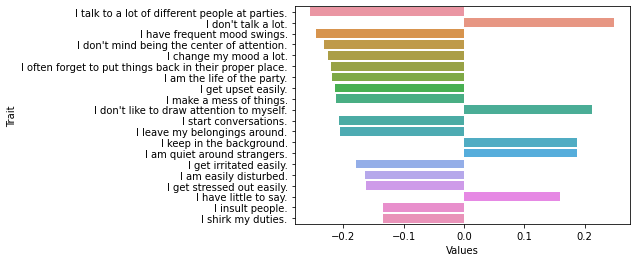

In [ ]:
vectordf, plotguy = vector_barchart(big5_df_column_names,V[2,:],10)

In [ ]:
big5_df.shape

(19719, 50)

# Other things